In [61]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.stats.power import TTestIndPower

In [62]:
def perform_power_analysis(effect_size, alpha, nobs1, desired_power, sample_sizes=None):
    """
    Выполняет анализ мощности и визуализирует зависимость мощности от размера выборки.
    
    Параметры:
      effect_size: Размер эффекта (Cohen's d)
      alpha: Уровень значимости
      nobs1: Размер выборки для группы A (предполагается равенство групп)
      desired_power: Желаемая мощность теста (например, 0.8 для 80%)
      sample_sizes: (Опционально) массив значений размера выборки для построения графика.
                    Если не задан, используется диапазон от 100 до 2000 с шагом 50.
    """
    analysis = TTestIndPower()
    
    current_power = analysis.power(effect_size=effect_size, nobs1=nobs1, alpha=alpha, ratio=1.0)
    print(f"Мощность теста при n = {nobs1}: {current_power:.4f}")
    
    required_n = analysis.solve_power(effect_size=effect_size, power=desired_power, alpha=alpha, ratio=1.0)
    print(f"Требуемый размер выборки на группу для мощности {desired_power*100:.0f}%: {required_n:.0f}")
    
    if sample_sizes is None:
        sample_sizes = np.arange(100, 2000, 50)
    
    powers = analysis.power(effect_size=effect_size, nobs1=sample_sizes, alpha=alpha, ratio=1.0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, powers, marker='o', linestyle='-', label='Мощность теста')
    plt.axhline(desired_power, color='red', linestyle='--', label=f'Желаемая мощность: {desired_power}')
    plt.xlabel('Размер выборки на группу')
    plt.ylabel('Мощность теста')
    plt.title("Зависимость мощности теста от размера выборки")
    plt.legend()
    plt.grid(True)
    plt.show()

In [63]:
np.random.seed(42)

In [64]:
n_A = 100
n_B = 100

# Генерация фейковых данных
# Допустим, у нас есть непрерывная метрика (например, выручка на пользователя)
# Группа A с средним значением 50 и стандартным отклонением 10
# Группа B с средним значением 55 и стандартным отклонением 10

In [65]:
group_A = np.random.normal(loc=50, scale=10, size=n_A)
group_B = np.random.normal(loc=55, scale=10, size=n_B)

# 1. Дескриптивная статистика

In [66]:
print("📊 Дескриптивная статистика:")
print("Group A: mean = {:.2f}, std = {:.2f}".format(np.mean(group_A), np.std(group_A, ddof=1)))
print("Group B: mean = {:.2f}, std = {:.2f}".format(np.mean(group_B), np.std(group_B, ddof=1)))

📊 Дескриптивная статистика:
Group A: mean = 48.96, std = 9.08
Group B: mean = 55.22, std = 9.54


# 2. Тест нормальности (Shapiro-Wilk)

In [67]:
shapiro_A = stats.shapiro(group_A)
shapiro_B = stats.shapiro(group_B)

print("\n🔍 Тест нормальности (Shapiro-Wilk):")
print(f"Group A: p-value = {shapiro_A.pvalue:.4f} {'✅ Норма' if shapiro_A.pvalue > 0.05 else '❌ НЕ норма'}")
print(f"Group B: p-value = {shapiro_B.pvalue:.4f} {'✅ Норма' if shapiro_B.pvalue > 0.05 else '❌ НЕ норма'}")


🔍 Тест нормальности (Shapiro-Wilk):
Group A: p-value = 0.6552 ✅ Норма
Group B: p-value = 0.0853 ✅ Норма


# 3. Тест равенства дисперсий (Levene)

In [68]:
levene_stat, levene_p = stats.levene(group_A, group_B)
equal_var = levene_p > 0.05  # Если p > 0.05, дисперсии можно считать равными

print("\n⚖️ Тест равенства дисперсий (Levene):")
print(f"p-value = {levene_p:.4f} {'✅ Дисперсии равны' if equal_var else '❌ Дисперсии разные'}")


⚖️ Тест равенства дисперсий (Levene):
p-value = 0.6715 ✅ Дисперсии равны


In [69]:
equal_var = True if levene_p > 0.05 else False
equal_var

True

# 4. Классический тест

In [70]:
t_stat, p_value = stats.ttest_ind(group_A, group_B, equal_var=equal_var)
print("\n📈 Классический t-test:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("🎉 A/B тест УСПЕШЕН! Различие статистически значимо. 🚀")
else:
    print("❌ A/B тест НЕ ПРОЙДЕН. Нет достаточных оснований утверждать, что группы различаются.")


📈 Классический t-test:
t-statistic = -4.7547, p-value = 0.0000
🎉 A/B тест УСПЕШЕН! Различие статистически значимо. 🚀


# 5. Расчёт эффекта (Cohen's d)

In [71]:
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohen_d(group_A, group_B)
print(f"\n📏 Cohen's d (размер эффекта): {d:.4f} {'(маленький эффект)' if abs(d) < 0.2 else '(средний эффект)' if abs(d) < 0.5 else '(большой эффект)'}")


📏 Cohen's d (размер эффекта): -0.6724 (большой эффект)


# 6. Визуализация результатов

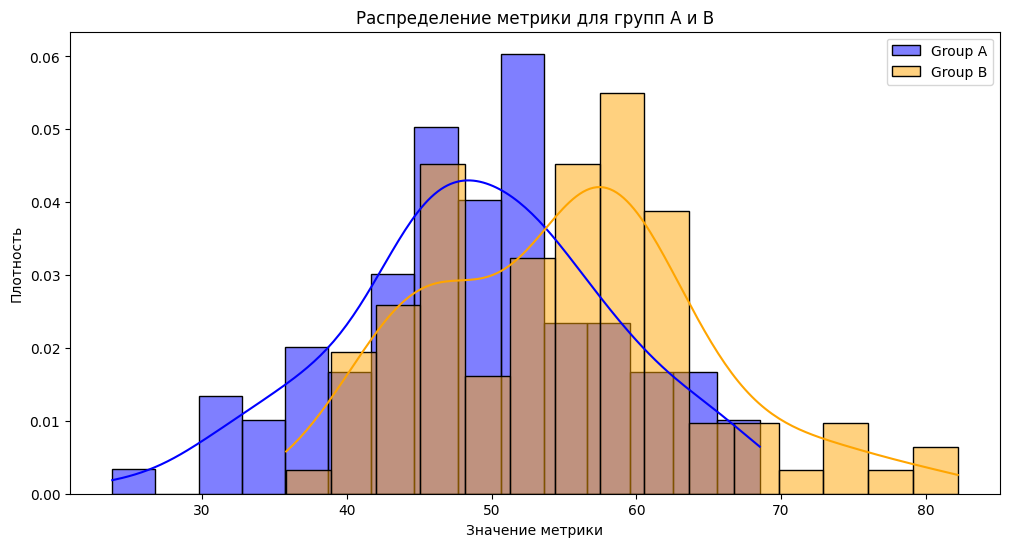

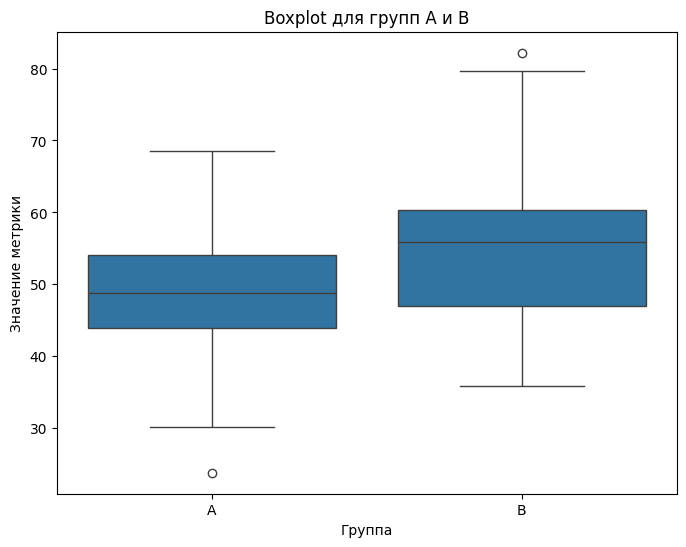

In [72]:
plt.figure(figsize=(12, 6))
sns.histplot(group_A, color='blue', label='Group A', kde=True, stat="density", bins=15)
sns.histplot(group_B, color='orange', label='Group B', kde=True, stat="density", bins=15)
plt.title('Распределение метрики для групп A и B')
plt.xlabel('Значение метрики')
plt.ylabel('Плотность')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
data = pd.DataFrame({'Group': ['A']*n_A + ['B']*n_B, 'Value': np.concatenate([group_A, group_B])})
sns.boxplot(x='Group', y='Value', data=data)
plt.title('Boxplot для групп A и B')
plt.xlabel('Группа')
plt.ylabel('Значение метрики')
plt.show()

Мощность теста при n = 1000: 1.0000
Требуемый размер выборки на группу для мощности 80%: 64


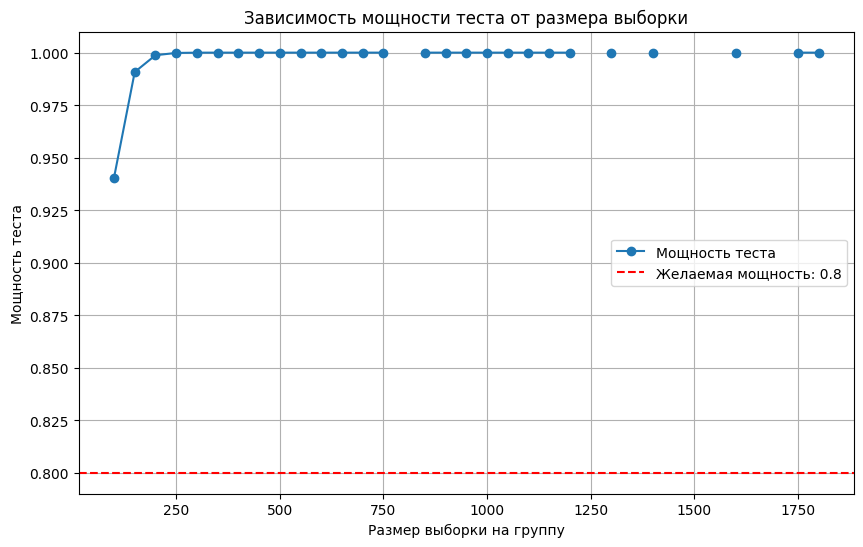

In [73]:
perform_power_analysis(effect_size=0.5, alpha=0.05, nobs1=1000, desired_power=0.8)